# ECSE 415 Final Project: Aman Sidhu (260885556) Partick Ohl (261182154)

# Setup

In [2]:
# Install ultralytics for YOLOv8n
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 10.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [3]:
# Imports
from ultralytics import YOLO
import cv2
import numpy as np
import math
from ultralytics.solutions import object_counter
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

%matplotlib inline

# Setup
from google.colab import drive
drive.mount('/content/drive')

base_folder = '/content/drive/My Drive/Colab Notebooks/ECSE415/Assignment6/'

Mounted at /content/drive


In [4]:
# Helper Functions for Report
def print_img(img, name = "", cmap = plt.get_cmap('gray')):
    plt.imshow(img, cmap=cmap)
    print(name + " Shape:", np.shape(img))
    plt.xticks([]), plt.yticks([])
    plt.show()

def plot_confusion_matrix(conf_matrix, title):
    class_names = ['Negative', 'Positive']
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap='viridis')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=class_names[::-1], yticklabels=class_names[::-1],  # Reversed order
           title="Confusion Matrix for " + title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
    fig.tight_layout()
    plt.show()

def calculate_metrics(TP, FP, TN, FN):
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return recall, precision, f1_score

# Description of Overall Approach and Assumptions

Our approach consist of 2 separate tasks:


**Identifying/Counting passed cars and people**

We keep track of the id's of any cars and people that we passed.

We assume that we pass an object according to:

*Assumption 1: Any person whose bounding box center is anywhere in the bottom 40% of the screen will be considered as passed, and for cars it is 26.5%.*

 From our testing, this helped with situations where objects might only be detected in the few frames before they are passed, and reduce instances where occlusion in the environment caused by moving cars and our moving perspective removes the chance of detecting an object. Tighter thresholds would perhaps be more rigorous but greatly reduce the window to detect objects. This threshold also helps reduce the times we recount the same object twice, and count objects near the end of the video that we would not have passed yet. We also assume that any person detected is a pedestrian, which would also include any bikers.

**Classifying passed cars as moving/parked**

The classification consists of 2 stages:



1.   **Initial Guess:**
  Based on the observation that moving cars are generally driving in the middle of the road (following a certain path), while parked cars are on the side of the road, we make the assumption that every car (we pass) that passes through a certain region of the screen is a moving car. We thus classify every car that passes through a certain line as moving and every other car as parked. This gives us a usable first guess for the classification.

2.   **Refinement Stage:**
This stage is based on the flow of the cars. We observed that the flow magnitudes have the general ordering
```
flow(moving_same_dir) < flow(parked) < flow(moving_opposite_dir)
```

which follows the idea that the speed of the cars relative to the dashcam (which follow above ordering) are reflected in the flow.

We use this observation along with :

*Assumption 2: All moving cars that we pass move in the same direction as each other*

which is a fair assumption when driving in the city (due to the restricted size of the streets). We then use K-means clustering with K=2 and our previous guess as initial labels in order to identify cars that the previous method may have misclassified. The resulting labels are our final classification.

**Note:** We define the flow magnitude of a car as the maximum of all mean flow magnitudes (excluding 0 flows) in the bounding boxes (for every frame) of a car. This is the flow-based feature we found that reflects above ordering the most consistently. When including other features such as flow-angle or the standard deviation in flow-angle, the results got worse.




# Software Packages Used

**YOLO (Ultralytics)**
You Only Look Once (YOLO), is a popular object detection and image segmentation model, originating from a paper called "You Only Look Once: Unified, Real-Time Object Detection" by Joseph Redmon et al. from the University of Washington. The original YOLO implementation uses a single CNN to predict bounding boxes and class probabilities directly from images in one evaluation. It first divides the image into a SxS grid, where it tries to find a suitable bounding box in each cell and the corresponding class confidence. Ultralytics provides an improved version of YOLO capable of providing fast, meaningful results and has a variety of extra features. Some features include detection, segmentation, pose estimation, tracking, and classification. For our purposes, we use a YOLOv8 model, which is pre-trained on the COCO dataset, for object classification, tracking, bounding box generation, and object counting.

**OpenCV**
Open Source Computer Vision Library (OpenCV) is a very popular computer vision library that provides many essential functionalities such as image processing, and feature extraction. In this project, OpenCV is used for
* reading the frames of the video
* preprocessing the frames
* running calcOpticalFlowFarneback to find the optical flow
* K-means Clustering

# Program Results

In [ ]:
# Provides initial analytics of the video
class Analyzer:
  def __init__(self, video_path):
      self.cap = cv2.VideoCapture(video_path)
      w, h = (int(self.cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT))
      self.frame_shape = (h, w)

      self.tracking_model = YOLO('yolov8n.pt')
      self.names = self.tracking_model.names

      self.passed_cars = set()
      self.tracked_flows = {}

      self.passed_people = set()

      self.bottom_threshold_cars = int(0.735*h)
      self.bottom_threshold_person = int(0.6*h)
      self.car_confidence_threshold = 0.8
      self.person_confidence_threshold = 0.6

      self.classes_to_count = [0, 2, 5, 7] # 0: person, 2: car, 5: bus, 7: truck
      self.count_names = {i: self.tracking_model.names[i] for i in self.classes_to_count}

      self.counter_moving_cars = object_counter.ObjectCounter()
      line_points = [(int(w*0.2), int(0.762*h)), (int(w*0.8), int(0.9125*h))]
      self.counter_moving_cars.set_args(view_img = True, reg_pts = line_points, classes_names = self.count_names, draw_tracks=True)


  def compute_flow(self, img1, img2, flow):
    return cv2.calcOpticalFlowFarneback(prev=img1,
                                        next=img2,
                                        flow=flow,
                                        pyr_scale=0.5,
                                        levels=3,
                                        winsize=15,
                                        iterations=3,
                                        poly_n=5,
                                        poly_sigma=1.2,
                                        flags=0 if flow is None else cv2.OPTFLOW_USE_INITIAL_FLOW
                                        )


  # Returns True if car, optionally adds it to passed_cars
  def check_passed_car(self, id, cls, box, conf):
    conf = math.ceil(conf*100)/100

    is_car = self.names[int(cls)] in ('bus', 'car', 'truck') and conf > self.car_confidence_threshold
    if is_car and id:
      x_tl, y_tl, x_br, y_bl = box
      if (y_tl + abs(y_tl - y_bl)//2) > self.bottom_threshold_cars:
        self.passed_cars.add(id)
    return is_car


  # Adds person to passed_people if we (are going to) pass them
  def check_passed_person(self, id, cls, box, conf):
    if self.names[int(cls)] == 'person' and conf > self.person_confidence_threshold:
            x_tl, y_tl, x_br, y_bl = box
            if (y_tl + abs(y_tl - y_bl)//2) > self.bottom_threshold_person:
              self.passed_people.add(id)


  def analyse_frame_data(self, tracks, flow_mags, flow_angles):
      flow_not_zero_mask = np.zeros(self.frame_shape)
      flow_not_zero_mask[flow_mags > 0] = 1

      boxes = tracks[0].boxes.xyxy.cpu()
      clss = tracks[0].boxes.cls.cpu().tolist()
      confs = tracks[0].boxes.conf.cpu().tolist()
      trk_ids = tracks[0].boxes.id.int().cpu().tolist()

      for (box, clss, trk_id, conf) in zip(boxes, clss, trk_ids, confs):
          trk_id = int(trk_id)
          # Count passed cars
          if self.check_passed_car(trk_id, clss, box, conf):
            # Compute flow data for every tracked car
            # Get tracking box as mask
            box_mask = np.zeros(self.frame_shape)
            box_mask[int(box[1]):int(box[3]), int(box[0]):int(box[2])] = 1
            # Get flow for tracked object
            n_flows_in_box = np.sum(box_mask*flow_not_zero_mask)
            mean_flow_mag = np.sum(flow_mags * box_mask) / n_flows_in_box
            # Update tracked flow features
            if trk_id in self.tracked_flows:
                self.tracked_flows[trk_id] = max(self.tracked_flows[trk_id], mean_flow_mag)
            else:
                self.tracked_flows[trk_id] = mean_flow_mag
          else:
            # Count passed persons
            self.check_passed_person(trk_id, clss, box, conf)


  def preprocess_frame(self, frame):
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      frame = cv2.equalizeHist(frame) # To improve robustness against lighting changes
      return frame


  def analyse(self):
    # Get first frame
    _, prev_frame = self.cap.read()
    prev_processed_frame = self.preprocess_frame(prev_frame)

    flow = None
    while True:
        # Get the next frame
        ret, frame = self.cap.read()
        if not ret:
            break
        # Preprocessing
        processed_frame = self.preprocess_frame(frame)
        # Compute dense optical flow
        flow = self.compute_flow(prev_processed_frame, processed_frame, flow)
        magnitude, angle = cv2.cartToPolar(flow[:, :, 0], flow[:, :, 1])
        # Track objects
        results = self.tracking_model.track(frame, classes=self.classes_to_count, persist=True, verbose=False, show=False)
        # Get first assumption of driving/parked
        self.counter_moving_cars.start_counting(frame, results)
        # Get corresponding flows
        self.analyse_frame_data(results, magnitude, angle)
        # Update previous frame
        prev_processed_frame = processed_frame

    self.cap.release()

  def get_results(self):
    return (self.passed_cars, self.counter_moving_cars.count_ids, self.tracked_flows, self.passed_people)

In [ ]:
def evaluate_results(video_name, analyzer):
  passed_cars, moving_ids, tracked_flows, passed_people = analyzer.get_results()

  car_ids = np.zeros(len(passed_cars))
  car_features = np.zeros((len(passed_cars)))

  # Convert flow data to numpy array corresponding to car ids
  for (i, c) in enumerate(passed_cars):
    max_mean_flow_mag = tracked_flows[c]

    car_ids[i] = c
    car_features[i] = max_mean_flow_mag
  # Normalize
  norm = np.linalg.norm(car_features, axis=0, keepdims=True)
  norm_car_features = car_features / norm

  # Get initial car labels (parked/moving)
  labels = np.zeros(norm_car_features.shape[0], dtype=np.int32)
  # For all cars that were detected as moving, change the label
  for id in moving_ids:
    # The id, features and label of a car are located at the same index
    car_index = np.where(car_ids == id)[0]
    labels[car_index] = 1

  # Apply clustering based on flow in order to refine results
  criteria = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS, 20, 0.05)
  cv2.kmeans(norm_car_features.astype(np.float32), K=2, bestLabels=labels,
                                            criteria=criteria, attempts=1, flags=cv2.KMEANS_USE_INITIAL_LABELS)
  parked_car_ids = car_ids[labels == 0]
  moving_car_ids = car_ids[labels == 1]

  # Output
  print('Results: ', video_name)
  print('# Passed Parked Cars: ', parked_car_ids.shape[0])
  print('# Passed Moving Cars: ', moving_car_ids.shape[0])
  print('# Passed People     : ', len(passed_people))

In [ ]:
analyzer_mcgill = Analyzer(base_folder + 'mcgill_drive.mp4')
analyzer_mcgill.analyse()

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Line Counter Initiated.


In [ ]:
analyzer_st_cath = Analyzer(base_folder + 'st-catherines_drive.mp4')
analyzer_st_cath.analyse()

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Line Counter Initiated.


In [ ]:
evaluate_results('mcgill_drive.mp4', analyzer_mcgill)
print()
evaluate_results('st-catherines_drive.mp4', analyzer_st_cath)

Results:  mcgill_drive.mp4
# Passed Parked Cars:  10
# Passed Moving Cars:  23
# Passed People     :  21

Results:  st-catherines_drive.mp4
# Passed Parked Cars:  50
# Passed Moving Cars:  4
# Passed People     :  61


**Results:**

St. Catherine
* Total Number of Passed Moving Cars: 4
* Total Number of Passed Parked Cars: 50
* Total Number of Pedestrians: 61

McGill Drive
* Total Number of Passed Moving Cars: 23
* Total Number of Passed Parked Cars: 10
* Total Number of Pedestrians: 21


**Ground Truth:**

St. Catherine
* Total Number of Passed Moving Cars: 2
* Total Number of Passed Parked Cars: 55
* Total Number of Pedestrians: 104

McGill Drive
* Total Number of Passed Moving Cars: 24
* Total Number of Passed Parked Cars: 10
* Total Number of Pedestrians: 35

Since the ground truth results were obtained manually, here is our process for classifying each. Pedestrians are any person either on the sidewalk, beside a car on the road, or crossing the street that is visible from the dashcam. Since bikers could be incorrectly detected as a person thus a false positive, when they are not detected they are true negative examples of pedestrians. While the definition for moving and parked cars are more straightforward, given by their names, stopped cars such as those at intersections waiting for a green light are not. Since they technically are not moving but also still in use, we exclude them from our analysis due to this discrepancy. True negatives for moving cars is the number of cars correctly classified as not moving (parked), and likewise for parked cars it is the amount cars marked as not parked (moving).

---------------------------------------

Looking at True Positive Counts in each video for all classes relative to ground truth we find:

* Pedestrian Detected: (St. Cath) 56.7% and (McGill Drive) 54.3%
* Moving Cars Detected: (St. Cath) 50% and (McGill Drive) 50%
* Parked Cars Detected: (St. Cath) 91% and (McGill Drive) 10%

In terms of program performance, we detected 50-60% of all pedestrians in each video. Any false positives were due to bikers, misclassifications, and repeat counts are kept to a minimum (2 per video). For moving cars, the program on the St. Catherine video had detected 3 false positives cases of moving cars, whereas it counted 10 false positives in McGill Drive. Similarly, almost all parked cars were mostly correctly determined in the St. Catherine video, but 9 detected parked cars in the McGill drive video were false positives causing it to perform very poorly. Overall, the program was effective in determining the correct total number of cars passed, but struggled with detecting 43-45% of all pedestrians. In distinguishing the number of moving and parked cars, our method seems to incorrectly classify these two classes on the busier street scene in the McGill Drive but has better success on the one-way road of St. Catherine.

# Discussion of Program Performance and Problems

Based on the above results, using a YOLO back-bone for the object detection seems to provide overall decent results with car, truck, and bus detection. Upon reviewing the annotated videos for each video, many distinct and clear examples of cars are correctly detected in both cases which is reflected in the number of total cars detected. For pedestrians, performance was generally good even in the more complicated St. Catherines video, however the model was not able to detect people consistently in poor lighting conditions. In general, occlusion did prevent some instances of people not being detected. In this case, perhaps a change to a more robust back-bone like Mask R-CNN could have provide better person detection. False positive of pedestrians were also kept low, but one or two bikers, random street objects, and counting an object twice did still occur.

Object tracking generally performed very well in both scenes with only a few cases where objects were sometimes classified with a new ID tag despite already being seen before. This was mitigated with decision to only count cars as they pass through the bottom of the screen. However, the low threshold for cars tended to exclude large vehicles like buses and trucks whose centers tended to be higher as they moved out of view.

The object_counter object used to get the initial classification of moving/parked cars is able to capture many cars that pass us, but can still be improved. Since moving cars and parked cars can sometime occupy the same region of the screen, we opted to be more conservative with the size of the line to avoid false positive moving cars. This meant that certain vehicles bounding box centers could miss the line and thus be misclassified as a parked car instead. Additionally, stopped cars moving the perpendicular direction at intersections may be incorrectly classified as parked since they appear on similar areas of the screen.
However, the refinement process could correct most of these mistakes. The dense flow estimation itself is very computationally intensive, which made testing more difficult. However, since the flow does not uniquely depend on the speed of the cars relative to the dashcam, but may also depend on the specific features observable in the bounding box and the angle at which a car is captured, the method may still be improved.

We also experimented with a version of the same program that does not use the flow portion to decide between moving and parked cars, but instead uses only the functionality provided in the Ultralytics library. This method did provide better results by minimizing the number of moving car false positives in the McGill Drive video from 10 to 0, and increasing the number of true positive parked cars from 1 to 10. It achieves similar results on the St. Catherine video, but detect 0 false positve moving cars. This method does improve how the program performs on these two videos, which shows that the potential issue is the optical flow portion which can refined in the future with more experimentation. Furthermore, we still believe that an approach using optical flow or another method to detect motion will be more robust than the streamlined version mentioned here. Below is the streamlined version for reference.

# Appendix

## Streamlined Version (Without Optical Flow)

This approach makes extensive use of the YOLO model features and functions from Ultralytics to perform key computer vision techniques needed for this problem: object detection/classification, multi-object tracking, and bounding box generation. Specifically, we use the pre-trained YOLOv8 model which is capable of these tasks, while providing fast and accurate results. Futhermore, as we are trying to detect number of passed cars and people in the scene, we limit the object detection to only focus on 'car', 'bus', 'truck', and 'person' objects.

Counting unique objects first involves creating a python set variable, an array which excludes repetitions, for both cars and pedestrians, respectively. In both sets, we include the tracking id of each passed pedestrian, and car even if it is parked or moving. This arises our first assumption: any person whose bounding box center is anywhere in the bottom 40% of the screen will be considered as passed, and for cars it is 26.5%. From our testing, this helped with situations where objects might only be detected in the few frames before they are passed, and reduce instances where occlusion in the environment caused by moving cars and our moving perspective removes the chance of detecting an object. Tighter thresholds would perhaps be more rigorous but greatly reduce the window to detect objects. This threshold also helps reduce the times we recount the same object twice, and count objects near the end of the video that we would not have passed yet. We also assume that any person detected is a pedestrian, which would also include any bikers. To distinguish between moving and parked cars, we use object_counter object from Ultralytics to count the tracking IDs of cars whose bounding box centers pass through a certain region of the screen, specifically a line. This approach tries to exploit how moving cars that we pass generally follow a path across the screen. This line is angled and positioned near the very bottom of the screen to ensure that only passed, moving cars are counted. This separate set of tracking IDs is then removed from the set of all car IDs to provide the final number of parked and moving cars. Lastly, a confidence threshold of 80% and 60% is used for cars and person objects, respectively, to ensure false positives of wrong objects is kept low.

In [5]:
path = '/content/drive/MyDrive/Olympus in the Sky/McGill/2024 - Winter/ECSE 415/Final Project/'

video_1 = 'st-catherines_drive.mp4'
video_2 = 'mcgill_drive.mp4'

model = YOLO("yolov8n.pt")
# Yolo, Object_Counter, threshold Arguments
classes_to_count            = [0, 2, 5, 7] # 0: person, 2: car, 5: bus, 7: truck
car_confidence_threshold    = 0.8
person_confidence_threshold = 0.6
count_names                 = {i: model.names[i] for i in classes_to_count}

for vid_num, video in enumerate((video_1, video_2)):
  cap = cv2.VideoCapture(path + video)
  assert cap.isOpened(), "Error reading video file"
  w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

  bottom_threshold_cars       = int(0.735*h)
  bottom_threshold_person     = int(0.6*h)

  # Init Object Counters
  # Tracks the motion of cars that pass through the bottom of the screen
  counter_cars = object_counter.ObjectCounter()
  line_points = [(int(w*0.2), int(0.762*h)), (int(w*0.8), int(0.9125*h))]
  counter_cars.set_args(view_img = True, reg_pts = line_points, classes_names = count_names, draw_tracks=True)

  # Video writer
  video_writer = cv2.VideoWriter("video_{}.avi".format(vid_num), cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

  unique_cars   = set()
  unique_people = set()

  while cap.isOpened():
      success, im0 = cap.read()
      if not success:
          print("Video frame is empty or video processing has been successfully completed.")
          break

      # Tracking
      tracks = model.track(im0, persist=True, show=False, classes=classes_to_count, verbose = False)

      # Process Bounding Boxes
      for r in tracks:
        for box in r.boxes:
          conf = math.ceil(box.conf[0]*100)/100

          # Count all cars and people that pass near the bottom 40% of the screen
          if r.names[int(box.cls[0])] in ('bus', 'car', 'truck') and conf > car_confidence_threshold:
            x_tl, y_tl, x_br, y_bl = box.xyxy[0]
            if (y_tl + abs(y_tl - y_bl)//2) > bottom_threshold_cars:
              unique_cars.add(int(box.id))

          if r.names[int(box.cls[0])] == 'person' and conf > person_confidence_threshold:
            x_tl, y_tl, x_br, y_bl = box.xyxy[0]
            if (y_tl + abs(y_tl - y_bl)//2) > bottom_threshold_person:
              unique_people.add(int(box.id))

      im0 = counter_cars.start_counting(im0, tracks)
      video_writer.write(im0)

  cap.release()
  video_writer.release()
  cv2.destroyAllWindows()

  print('-'*100)
  print('Video: ' + video)
  all_cars = len(unique_cars)
  print('Total Number of Cars: {}'.format(all_cars)) # all cars

  for moving_car in counter_cars.count_ids:
    unique_cars.discard(moving_car)

  parked_cars = len(unique_cars)
  print('Total Number of Parked Cars: {}'.format(parked_cars)) # all cars - marked outbound cars
  print('Total Number of Moving Cars: {}'.format(len(counter_cars.count_ids))) # number of moving cars
  print('Total Number of Pedestrians: {}'.format(len(unique_people))) # number of passed cars

100%|██████████| 6.23M/6.23M [00:00<00:00, 56.8MB/s]


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Line Counter Initiated.
requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 6.3s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Video frame is empty or video processing has been successfully completed.
----------------------------------------------------------------------------------------------------
Video: st-catherines_drive.mp4
Total Number of Cars: 54
Total Number of Parked Cars: 53
Total Number of Moving Cars: 1
Total Number of Pedestrians: 61
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Line Counter Initiated.
Video frame is empty or video processing has been successfully completed.
------------------------------------------------------------------------------

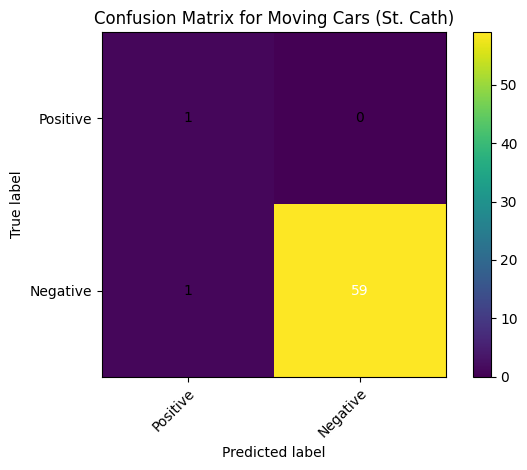

Recall: 0.5
Precision: 1.0
F1 Score: 0.6666666666666666

----------------------------------------------------------------------------------------------------



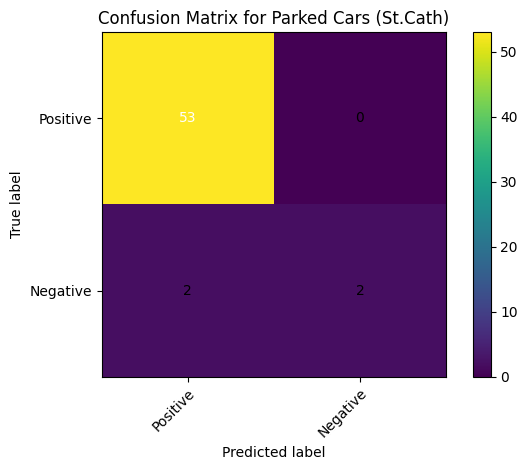

Recall: 0.9636363636363636
Precision: 1.0
F1 Score: 0.9814814814814815

----------------------------------------------------------------------------------------------------



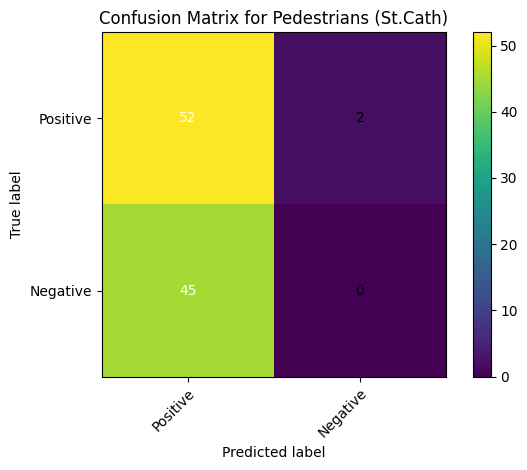

Recall: 0.5360824742268041
Precision: 0.9629629629629629
F1 Score: 0.6887417218543046


In [6]:
# Moving Cars
TP = 1
FP = 0
TN = 59
FN = 1

res_st_cath = []
conf_matrix = np.array([[TP, FP], [FN, TN]])
recall, precision, f1_score = calculate_metrics(TP, FP, TN, FN)
res_st_cath.append([recall, precision, f1_score])

plot_confusion_matrix(conf_matrix, 'Moving Cars (St. Cath)')
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)

print('\n' + '-'*100 + '\n')

# Parked Cars
TP = 53
FP = 0
TN = 2
FN = 2

conf_matrix = np.array([[TP, FP], [FN, TN]])
recall, precision, f1_score = calculate_metrics(TP, FP, TN, FN)
res_st_cath.append([recall, precision, f1_score])

plot_confusion_matrix(conf_matrix, 'Parked Cars (St.Cath)')
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)

print('\n' + '-'*100 + '\n')

# Pedestrians
TP = 52
FP = 2
TN = 0
FN = 45

conf_matrix = np.array([[TP, FP], [FN, TN]])
recall, precision, f1_score = calculate_metrics(TP, FP, TN, FN)
res_st_cath.append([recall, precision, f1_score])

plot_confusion_matrix(conf_matrix, 'Pedestrians (St.Cath)')
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)

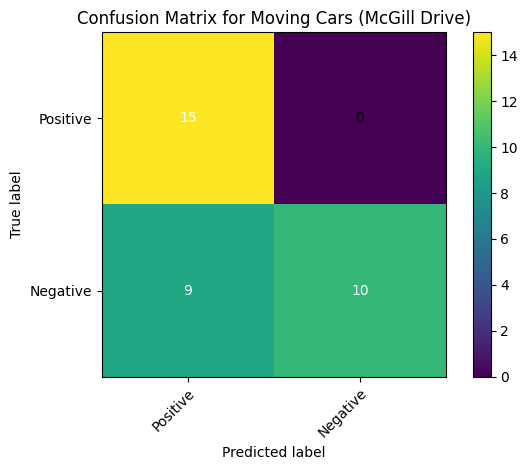

Recall: 0.625
Precision: 1.0
F1 Score: 0.7692307692307693

----------------------------------------------------------------------------------------------------



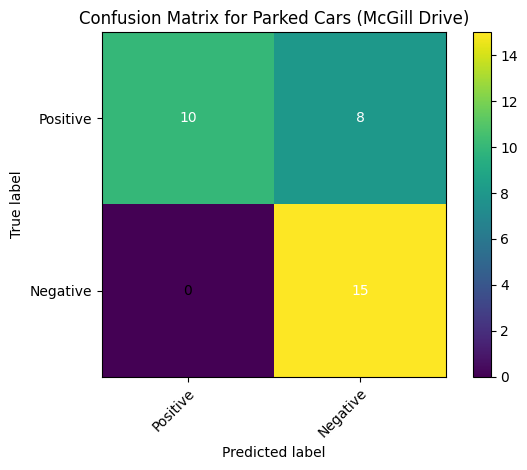

Recall: 1.0
Precision: 0.5555555555555556
F1 Score: 0.7142857142857143

----------------------------------------------------------------------------------------------------



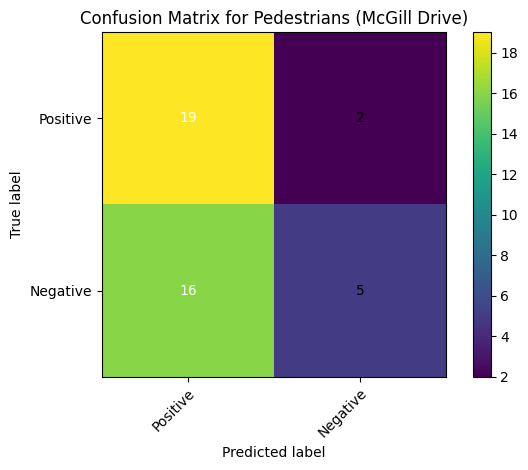

Recall: 0.5428571428571428
Precision: 0.9047619047619048
F1 Score: 0.6785714285714285


In [7]:
# Moving Cars
TP = 15
FP = 0
TN = 10
FN = 9

res_mcgill_drive = []
conf_matrix = np.array([[TP, FP], [FN, TN]])
recall, precision, f1_score = calculate_metrics(TP, FP, TN, FN)
res_mcgill_drive.append([recall, precision, f1_score])

plot_confusion_matrix(conf_matrix, 'Moving Cars (McGill Drive)')
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)

print('\n' + '-'*100 + '\n')

# Parked Cars
TP = 10
FP = 8
TN = 15
FN = 0

conf_matrix = np.array([[TP, FP], [FN, TN]])
recall, precision, f1_score = calculate_metrics(TP, FP, TN, FN)
res_mcgill_drive.append([recall, precision, f1_score])

plot_confusion_matrix(conf_matrix, 'Parked Cars (McGill Drive)')
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)

print('\n' + '-'*100 + '\n')

# Pedestrians
TP = 19
FP = 2
TN = 5
FN = 16

conf_matrix = np.array([[TP, FP], [FN, TN]])
recall, precision, f1_score = calculate_metrics(TP, FP, TN, FN)
res_mcgill_drive.append([recall, precision, f1_score])

plot_confusion_matrix(conf_matrix, 'Pedestrians (McGill Drive)')
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)